
# CEWA 568 Snow Hydrology - Spring 2023
## Homework 7

Daniel Hogan

---

In [1]:
import os
import urllib
from urllib.error import URLError
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt

import metpy
import metpy.calc as calc
from metpy.units import units
import pint_xarray

import matplotlib.pyplot as plt

# Inputs

Below, you can see that we are pulling in a lot of turbulence data.  These data are the mean values (one variable) and variances (two variables) over 5-minute intervals at each height.  w represents winds in the vertical direction, and u and v represent winds in the horizontal.  tc is the sonic temperature, based in the speed of sound, and h2o is the water vapor concentration (or specific humidity).  Thus, we represent vertical sensible heat flux by 'w_tc__height_tower' and vertical latent heat flux by 'w_h2o_height_tower'

In [2]:
# data is downloaded to this file path
sos_download_dir='../data/sosnoqc'

# Specify start and end dates for the data. Specify the format that the dates are in.
# start_date = '20221201'
# end_date = '20221210'



# Specify the variables you want to download. We are grabbing it ALL this time around.
VARIABLE_NAMES = [
    # Sonic Anemometer Data for 4 towers
    'tc_1m_uw',     'spd_1m_uw',     'dir_1m_uw',     'u_1m_uw',   'v_1m_uw',   'w_1m_uw',   'u_u__1m_uw',    'v_v__1m_uw',    'w_w__1m_uw',    
        'u_w__1m_uw',    'v_w__1m_uw',  'u_tc__1m_uw',  'v_tc__1m_uw',   'u_h2o__1m_uw',  'v_h2o__1m_uw',   'w_tc__1m_uw',   'w_h2o__1m_uw',
    'tc_3m_uw',     'spd_3m_uw',     'dir_3m_uw',     'u_3m_uw',   'v_3m_uw',   'w_3m_uw',   'u_u__3m_uw',    'v_v__3m_uw',    'w_w__3m_uw',    
        'u_w__3m_uw',    'v_w__3m_uw',  'u_tc__3m_uw',  'v_tc__3m_uw',   'u_h2o__3m_uw',  'v_h2o__3m_uw',   'w_tc__3m_uw',   'w_h2o__3m_uw',
    'tc_10m_uw',    'spd_10m_uw',    'dir_10m_uw',    'u_10m_uw',  'v_10m_uw',  'w_10m_uw',  'u_u__10m_uw',   'v_v__10m_uw',   'w_w__10m_uw',   
        'u_w__10m_uw',   'v_w__10m_uw', 'u_tc__10m_uw', 'v_tc__10m_uw',  'u_h2o__10m_uw', 'v_h2o__10m_uw',  'w_tc__10m_uw',  'w_h2o__10m_uw',

    'tc_1m_ue',     'spd_1m_ue',     'dir_1m_ue',     'u_1m_ue',   'v_1m_ue',   'w_1m_ue',   'u_u__1m_ue',    'v_v__1m_ue',    'w_w__1m_ue',    
        'u_w__1m_ue',    'v_w__1m_ue',  'u_tc__1m_ue',  'v_tc__1m_ue',   'u_h2o__1m_ue',  'v_h2o__1m_ue',   'w_tc__1m_ue',   'w_h2o__1m_ue',
    'tc_3m_ue',     'spd_3m_ue',     'dir_3m_ue',     'u_3m_ue',   'v_3m_ue',   'w_3m_ue',   'u_u__3m_ue',    'v_v__3m_ue',    'w_w__3m_ue',    
        'u_w__3m_ue',    'v_w__3m_ue',  'u_tc__3m_ue',  'v_tc__3m_ue',   'u_h2o__3m_ue',  'v_h2o__3m_ue',   'w_tc__3m_ue',   'w_h2o__3m_ue',
    'tc_10m_ue',    'spd_10m_ue',    'dir_10m_ue',    'u_10m_ue',  'v_10m_ue',  'w_10m_ue',  'u_u__10m_ue',   'v_v__10m_ue',   'w_w__10m_ue',   
        'u_w__10m_ue',   'v_w__10m_ue', 'u_tc__10m_ue', 'v_tc__10m_ue',  'u_h2o__10m_ue', 'v_h2o__10m_ue',  'w_tc__10m_ue',  'w_h2o__10m_ue',

    'tc_1m_d',      'spd_1m_d',     'dir_1m_d',     'u_1m_d',   'v_1m_d',   'w_1m_d',   'u_u__1m_d',    'v_v__1m_d',    'w_w__1m_d',    
        'u_w__1m_d',    'v_w__1m_d',  'u_tc__1m_d',  'v_tc__1m_d',   'u_h2o__1m_d',  'v_h2o__1m_d',   'w_tc__1m_d',   'w_h2o__1m_d',
    'tc_3m_d',      'spd_3m_d',     'dir_3m_d',     'u_3m_d',   'v_3m_d',   'w_3m_d',   'u_u__3m_d',    'v_v__3m_d',    'w_w__3m_d',    
        'u_w__3m_d',    'v_w__3m_d',  'u_tc__3m_d',  'v_tc__3m_d',   'u_h2o__3m_d',  'v_h2o__3m_d',   'w_tc__3m_d',   'w_h2o__3m_d',
    'tc_10m_d',     'spd_10m_d',    'dir_10m_d',    'u_10m_d',  'v_10m_d',  'w_10m_d',  'u_u__10m_d',   'v_v__10m_d',   'w_w__10m_d',   
        'u_w__10m_d',   'v_w__10m_d', 'u_tc__10m_d', 'v_tc__10m_d',  'u_h2o__10m_d', 'v_h2o__10m_d',  'w_tc__10m_d',  'w_h2o__10m_d',

    'tc_2m_c',  'spd_2m_c',     'dir_2m_c',     'u_2m_c',   'v_2m_c',   'w_2m_c',   'u_u__2m_c',    'v_v__2m_c',    'w_w__2m_c',    
        'u_w__2m_c',    'v_w__2m_c',  'u_tc__2m_c',  'v_tc__2m_c',   'u_h2o__2m_c',  'v_h2o__2m_c',   'w_tc__2m_c',   'w_h2o__2m_c',
    'tc_3m_c',  'spd_3m_c',     'dir_3m_c',     'u_3m_c',   'v_3m_c',   'w_3m_c',   'u_u__3m_c',    'v_v__3m_c',    'w_w__3m_c',    
        'u_w__3m_c',    'v_w__3m_c',  'u_tc__3m_c',  'v_tc__3m_c',   'u_h2o__3m_c',  'v_h2o__3m_c',   'w_tc__3m_c',   'w_h2o__3m_c',
    'tc_5m_c',  'spd_5m_c',     'dir_5m_c',     'u_5m_c',   'v_5m_c',   'w_5m_c',   'u_u__5m_c',    'v_v__5m_c',    'w_w__5m_c',    
        'u_w__5m_c',    'v_w__5m_c',  'u_tc__5m_c',  'v_tc__5m_c',   'u_h2o__5m_c',  'v_h2o__5m_c',   'w_tc__5m_c',   'w_h2o__5m_c',
    'tc_10m_c', 'spd_10m_c',    'dir_10m_c',    'u_10m_c',  'v_10m_c',  'w_10m_c',  'u_u__10m_c',   'v_v__10m_c',   'w_w__10m_c',   
        'u_w__10m_c',   'v_w__10m_c', 'u_tc__10m_c', 'v_tc__10m_c',  'u_h2o__10m_c', 'v_h2o__10m_c',  'w_tc__10m_c',  'w_h2o__10m_c',
    'tc_15m_c', 'spd_15m_c',    'dir_15m_c',    'u_15m_c',  'v_15m_c',  'w_15m_c',  'u_u__15m_c',   'v_v__15m_c',   'w_w__15m_c',   
        'u_w__15m_c',   'v_w__15m_c', 'u_tc__15m_c', 'v_tc__15m_c',  'u_h2o__15m_c', 'v_h2o__15m_c',  'w_tc__15m_c',  'w_h2o__15m_c',
    'tc_20m_c', 'spd_20m_c',    'dir_20m_c',    'u_20m_c',  'v_20m_c',  'w_20m_c',  'u_u__20m_c',   'v_v__20m_c',   'w_w__20m_c',   
        'u_w__20m_c',   'v_w__20m_c', 'u_tc__20m_c', 'v_tc__20m_c',  'u_h2o__20m_c', 'v_h2o__20m_c',  'w_tc__20m_c',  'w_h2o__20m_c',

    
    # Temperature & Relative Humidity Array 
    'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
    'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

    # Pressure Sensors
    'P_20m_c',
    'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

    # Blowing snow/FlowCapt Sensors
    'SF_avg_1m_ue', 'SF_avg_2m_ue',

    # Apogee sensors
    "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
    "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
    "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

    # Snow-level temperature arrays (towers D and UW)
    'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
    'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
    
    # Downward Facing Longwave Radiometer (tower D) - for measuring snow surface temperature
    'Rpile_out_9m_d',
    'Tcase_out_9m_d',
    
    # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
    'Rsw_in_9m_d',
]

# Define some functions we will use

Some of these you have seen before.

In [3]:
def download_sos_data_day(date, local_download_dir, cache=True):
    """Download a netcdf file from the ftp url provided by the Earth Observing 
    Laboratory at NCAR. Data comes in one NetCDF file per day, Reynolds-Averaged 
    with a 5-minute averaging period.

    Args:
        date (str, optional): String representing a date in format '%Y%m%d'. Defaults to '20221101'.
        local_download_dir (str, optional): Directory to which files will be downloaded. Defaults 
                    to 'sosnoqc'; this directory will be created if it  does not already exist.
        cache (bool, optional): If True, looks in `local_download_dir` for requested  file, if it 
                    exists, does not redownload file. If False, downloads file from the FTP server.

    Returns:
        _type_: Relative path to the downloaded file
    """
    base_url = 'ftp.eol.ucar.edu'
    path = 'pub/archive/isfs/projects/SOS/netcdf/noqc_geo'
    file = f'isfs_{date}.nc'
    os.makedirs(local_download_dir, exist_ok=True)
    full_file_path = os.path.join('ftp://', base_url, path, file)
    download_file_path = os.path.join(local_download_dir, file)
    if cache and os.path.isfile(download_file_path):
        print(f"Caching...skipping download for {date}")
    else:
        urllib.request.urlretrieve(
            full_file_path,
            download_file_path   
        )
    return download_file_path

def merge_datasets_with_different_variables(ds_list, dim):
    """ Allows merging of xarray datasets with different data variables.
    Takes a list of datasets and merges two at a time them using xr.merge, but first checks that the two datasets
    have the same data vars. If they do not, datasets with missing data vars have the missing data var added to them,
    with all nan values, so that the two datasets have the same set of data vars. 
    
    WARNING: This gets slow with lots of datasets
    Args:
        ds_list (_type_): _description_
        dim (_type_): _description_
    """
    def _merge_datasets_with_different_variables(ds1, ds2, dim):
        vars1 = set(ds1.data_vars)
        vars2 = set(ds2.data_vars)
        in1_notin2 = vars1.difference(vars2)
        in2_notin1 = vars2.difference(vars1)
        # add vars with NaN values to ds1
        for v in in2_notin1:
            ds1[v] = xr.DataArray(coords=ds1.coords, dims=ds1.dims)
        # add vars with NaN values to ds2
        for v in in1_notin2:
            ds2[v] = xr.DataArray(coords=ds2.coords, dims=ds2.dims)
        return xr.concat([ds1, ds2], dim=dim)

    new_ds = ds_list.pop(0)
    while ds_list:
        new_ds = _merge_datasets_with_different_variables(
            new_ds,
            ds_list.pop(0),
            dim=dim
        )
    return new_ds

from datetime import datetime
from dateutil.relativedelta import relativedelta
def date_range(start_date, end_date, increment, period):
    """Create a list of datetimes starting on a start_date, ending on end_date,
    with incrememnts of `increment` `period` between them.
    """
    result = []
    nxt = start_date
    delta = relativedelta(**{period:increment})
    while nxt <= end_date:
        result.append(nxt)
        nxt += delta

    return result


def apogee2temp(ds,tower):
    # hard-coded sensor-specific calibrations
    Vref = 2.5
    ID = ds[f"IDir_{tower}"]
    sns = [136, 137, 138, 139, 140]
    im = [ sns.index(x) if x in sns else None for x in ID ][0]
    # unclear if we want these, or scaled up versions
    mC0 = [57508.575,56653.007,58756.588,58605.7861, 58756.588][im] * 1e5
    mC1 = [289.12189,280.03380,287.12487,285.00285, 287.12487][im] * 1e5
    mC2 = [2.16807,2.11478,2.11822,2.08932, 2.11822][im] * 1e5
    bC0 = [-168.3687,-319.9362,-214.5312,-329.6453, -214.5312][im]* 1e5
    bC1 = [-0.22672,-1.23812,-0.59308,-1.24657, -0.59308][im]* 1e5
    bC2 = [0.08927,0.08612,0.10936,0.09234, 0.10936][im]* 1e5
    # read data
    Vtherm = ds[f"Vtherm_{tower}"]
    Vpile = ds[f"Vpile_{tower}"]*1000
    # calculation of detector temperature from Steinhart-Hart
    Rt = 24900.0/((Vref/Vtherm) - 1)
    Ac = 1.129241e-3
    Bc = 2.341077e-4
    Cc = 8.775468e-8
    TDk = 1/(Ac + Bc*np.log(Rt) + Cc*(np.log(Rt)**3))
    TDc = TDk - 273.15
    # finally, calculation of "target" temperature including thermopile measurement
    m = mC2*TDc**2 + mC1*TDc + mC0
    b = bC2*TDc**2 + bC1*TDc + bC0
    TTc = (TDk**4 + m*Vpile + b)**0.25 - 273.15
    # sufs = suffixes(TTc,leadch='') # get suffixes
    # dimnames(TTc)[[2]] = paste0("Tsfc.Ap.",sufs)
    TTc = TTc * units('celsius')
    return TTc


# Download SoS data

# Fill in missing timestamps (with nans)

Note that this occurs if there is missing data (i.e. power went down) at the beginning or end of day - those timestamps will be left out of the dataset. 

The following code makes sure that if a timestamp is missing from the dataset, it is added with NaNs for all variables.

This results in daily datasets of different size (for example, the 20221201 dataset is missing data at the end of the day), which is annoying and can get confusing when you merge datasets together

# Calculate new variables

## Calculate surface temperatures

For calculating the temperature from the downward-facing, longwave radiometer, see EOL's methodology (https://www.eol.ucar.edu/content/calculation-long-wave-radiation)
$$
R_{lw} = R_{pile} + SB * T_{case}^4
$$
And the Steven-Boltzman law
$$
T_{surface} = \Big( \frac {R_{lw}}{ \epsilon \sigma } \Big)^\frac{1}{4}
$$

In [4]:
def calc_surface_temp(ds):
    SB = 5.67e-08 # steven boltzman constant, W/m^2/degK^4
    SNOW_EMMISIVITY = 0.98
    ds['Tsurf_rad_d'] = ((ds['Rpile_out_9m_d'] + SB * (ds['Tcase_out_9m_d']+273.15)**4)/(SNOW_EMMISIVITY*SB))**(1/4) - 273.15

    # Surface Temperature
    # calculate from apogees
    ds['Tsurf_c'] = (['time'], apogee2temp(ds, 'c').values)
    ds['Tsurf_d'] = (['time'], apogee2temp(ds, 'd').values)
    ds['Tsurf_ue'] = (['time'], apogee2temp(ds, 'ue').values)
    ds['Tsurf_uw'] = (['time'], apogee2temp(ds, 'uw').values)
    return ds

## Calculate potential and virtual potential temperatures in the air

We iterate over every sonic-anemometer-height on the central (c) tower and calculate 5 new variables for each height:


mixingratio - **mixing ratio, r**
$$ r = \frac{0.622e_v}{p-e_v} $$
Remember that the mixing ratio is the ratio of the mass of water vapor to the mass of dry air only.  The specific humidity is the ratio of the mass of water vapor to the total mass of the air, but for practical purposes, we can presume they are the same.  $p$ is the air pressure (measured), and $e_v$ is the vapor pressure, which is calculated from the relative humidity (measured, in fractional form) times the saturated vapor pressure, which is an empirical function of temperature (measured) as shown in Lab 6-4.  



airdensity - **air density, $\rho$**
$$ p = \rho RT $$
From the ideal gas law, we can relate pressure to density, the gas constant for the specific gas, and the temperature (in Kelvin).  We know that the gas constant for dry air is $461.5 J kg^{-1} K^{-1}$, and the gas constant for water vapor is $286.9 J kg^{-1} K^{-1}$.  Knowing the observed pressure, temperature, and mixing ratio (calculated above) allows us to calculate the air density.



Tvirtual - **virtual temperature, $T_v$**
$$ T_v = T(1+0.61r) $$
where $T$ is the air temperature, and $r$ is the mixing ratio.  We use the virtual temperature to account for the fact that the density of air changes with water vapor concentration (moist air is less dense than dry air).  



Tpot - **potential temperature, $\theta$**
$$ \theta = T \Big(\frac{100}{p}\Big)^{\frac{R_a}{c_p}} $$
where $T$ is the air temperature in K, $p$ is the air pressure in kPa, $R_a$ is the specific gas constant for moist air, and $c_p$ is the specific heat for moist air.


Tpotvirtual - **virtual potential temperature, $\theta_v$**
This is an analagous adjustment as to the potential temperature, but it is done to the virtual temperature instead.




Note that we use the `metpy` library here, which assigns units to each dataarray, in an "object oriented" way using the `pint` library. You don't really have to worry about this, only to know that it can make working with the data more confusing. Know that at the end of the following cell, when we assign the new variables to the dataset, we remove any remnants of the `pint` library, and we assign an attribute `units` to each new variable so that they somewhat match the variables provided in the original dataset.

## Calculate virtual potential temperatures at the snow surface

These are pretty much the same calculations as above, except we use the snow surface temperature from the longwave radiometer instead of air temperature.

Also, we assume that the air immediately next to the snow is saturated and at saturation vapor pressure.  Thus, the relative humidity at the snow surface is 100%.

In [5]:
def calc_atm_metrics(ds):
    # Potential Temperature
    # iterate over pressure measurements
    for i in range(2,21):
        absolute_temperature = ds[f'T_{i}m_c'] * units.celsius
        relative_humidity = ds[f'RH_{i}m_c']
        absolute_pressure = ds['P_10m_c'] * units.millibar
        height_relative_to_10m_pressure_sensor = i*units.m - (10*units.m)

        height_adj_pressure = calc.add_height_to_pressure(
            absolute_pressure, 
            height_relative_to_10m_pressure_sensor
        )
        potential_temperature = calc.potential_temperature(    
                height_adj_pressure,
                absolute_temperature
        ).pint.to(units.celsius)
        mixing_ratio = xr.DataArray(relative_humidity/100) * calc.saturation_mixing_ratio(
            height_adj_pressure,
            absolute_temperature
        )
        air_density = calc.density(height_adj_pressure, absolute_temperature, mixing_ratio)
        virtual_potential_temperature = calc.virtual_temperature(
            potential_temperature,
            mixing_ratio,
        )

        virtual_temperature = calc.virtual_temperature(
            absolute_temperature,
            mixing_ratio,
        )
    
        ds[f'Tpot_{i}m_c'] = (['time'], potential_temperature.pint.magnitude)
        ds[f'Tpot_{i}m_c'] = ds[f'Tpot_{i}m_c'].assign_attrs(units = str(potential_temperature.pint.units))

        ds[f'Tvirtual_{i}m_c'] = (['time'], virtual_temperature.pint.magnitude)
        ds[f'Tvirtual_{i}m_c'] = ds[f'Tvirtual_{i}m_c'].assign_attrs(units = str(virtual_temperature.pint.units))

        ds[f'Tpotvirtual_{i}m_c'] = (['time'], virtual_potential_temperature.pint.magnitude)
        ds[f'Tpotvirtual_{i}m_c'] = ds[f'Tpotvirtual_{i}m_c'].assign_attrs(units = str(virtual_potential_temperature.pint.units))

        ds[f'airdensity_{i}m_c'] = (['time'], air_density.pint.magnitude)
        ds[f'airdensity_{i}m_c'] = ds[f'airdensity_{i}m_c'].assign_attrs(units = str(air_density.pint.units))

        ds[f'mixingratio_{i}m_c'] = (['time'], mixing_ratio.pint.magnitude)
        ds[f'mixingratio_{i}m_c'] = ds[f'mixingratio_{i}m_c'].assign_attrs(units = str(mixing_ratio.pint.units))
    
    height_relative_to_10m_pressure_sensor = - (10*units.m)
    absolute_temperature = ds['Tsurf_rad_d']*units.celsius
    relative_humidity = 100

    potential_temperature = metpy.calc.potential_temperature(    
        height_adj_pressure,
        absolute_temperature
    ).pint.to(units.celsius)

    mixing_ratio = xr.DataArray(relative_humidity/100) * metpy.calc.saturation_mixing_ratio(
            height_adj_pressure,
            absolute_temperature
        )
    air_density = metpy.calc.density(height_adj_pressure, absolute_temperature, mixing_ratio)

    virtual_potential_temperature = metpy.calc.virtual_temperature(
        potential_temperature,
        mixing_ratio,
    )

    virtual_temperature = metpy.calc.virtual_temperature(
        absolute_temperature,
        mixing_ratio,
    )

    ds[f'Tsurfvirtual_rad_c'] = (['time'], virtual_temperature.pint.magnitude)
    ds[f'Tsurfvirtual_rad_c'] = ds[f'Tsurfvirtual_rad_c'].assign_attrs(units = str(virtual_temperature.pint.units))

    ds[f'Tsurfpotvirtual_rad_c'] = (['time'], virtual_potential_temperature.pint.magnitude)
    ds[f'Tsurfpotvirtual_rad_c'] = ds[f'Tsurfpotvirtual_rad_c'].assign_attrs(units = str(virtual_potential_temperature.pint.units))

    ds[f'Tsurfairdensity_rad_c'] = (['time'], air_density.pint.magnitude)
    ds[f'Tsurfairdensity_rad_c'] = ds[f'Tsurfairdensity_rad_c'].assign_attrs(units = str(air_density.pint.units))

    ds[f'Tsurfmixingratio_rad_c'] = (['time'], mixing_ratio.pint.magnitude)
    ds[f'Tsurfmixingratio_rad_c'] = ds[f'Tsurfmixingratio_rad_c'].assign_attrs(units = str(mixing_ratio.pint.units))

    ds[f'Tsurfpot_rad_c'] = (['time'], potential_temperature.pint.magnitude)
    ds[f'Tsurfpot_rad_c'] = ds[f'Tsurfpot_rad_c'].assign_attrs(units = str(potential_temperature.pint.units))
    return ds


## Calculate turbulent kinetic energy

Turbulent kinetic energy, TKE, is the energy per uit mass associated with turbulent fluctuations in the atmosphere.  We often consider it a measure of the strength of atmospheric turbulence.  It is generated by buoyancy (in unstable conditions) and by wind shear, and it is suppressed by buoyancy (in stable conditions) and by dissipation.

$$
TKE = \frac{\overline{(u')^2}+\overline{(v')^2}+\overline{(w')^2}}{2}
$$

In [6]:
def calc_tke(ds):
    ds['tke_2m_c'] = 0.5*(ds['u_u__2m_c'] + ds['v_v__2m_c'] + ds['w_w__2m_c'])
    ds['tke_3m_c'] = 0.5*(ds['u_u__3m_c'] + ds['v_v__3m_c'] + ds['w_w__3m_c'])
    ds['tke_5m_c'] = 0.5*(ds['u_u__5m_c'] + ds['v_v__5m_c'] + ds['w_w__5m_c'])
    ds['tke_10m_c'] = 0.5*(ds['u_u__10m_c'] + ds['v_v__10m_c'] + ds['w_w__10m_c'])
    ds['tke_15m_c'] = 0.5*(ds['u_u__15m_c'] + ds['v_v__15m_c'] + ds['w_w__15m_c'])
    ds['tke_20m_c'] = 0.5*(ds['u_u__20m_c'] + ds['v_v__20m_c'] + ds['w_w__20m_c'])

    ds['tke_1m_uw'] = 0.5*(ds['u_u__1m_uw'] + ds['v_v__1m_uw'] + ds['w_w__1m_uw'])
    ds['tke_3m_uw'] = 0.5*(ds['u_u__3m_uw'] + ds['v_v__3m_uw'] + ds['w_w__3m_uw'])
    ds['tke_10m_uw'] = 0.5*(ds['u_u__10m_uw'] + ds['v_v__10m_uw'] + ds['w_w__10m_uw'])

    ds['tke_1m_ue'] = 0.5*(ds['u_u__1m_ue'] + ds['v_v__1m_ue'] + ds['w_w__1m_ue'])
    ds['tke_3m_ue'] = 0.5*(ds['u_u__3m_ue'] + ds['v_v__3m_ue'] + ds['w_w__3m_ue'])
    ds['tke_10m_ue'] = 0.5*(ds['u_u__10m_ue'] + ds['v_v__10m_ue'] + ds['w_w__10m_ue'])

    ds['tke_1m_d'] = 0.5*(ds['u_u__1m_d'] + ds['v_v__1m_d'] + ds['w_w__1m_d'])
    ds['tke_3m_d'] = 0.5*(ds['u_u__3m_d'] + ds['v_v__3m_d'] + ds['w_w__3m_d'])
    ds['tke_10m_d'] = 0.5*(ds['u_u__10m_d'] + ds['v_v__10m_d'] + ds['w_w__10m_d'])
    return ds

## Calculate gradients and the Richardson number

From https://glossary.ametsoc.org/wiki/Gradient_richardson_number

The Richardson number is a measure of the ratio of buoyant forces to shear forces in a fluid.  

A simplified gradient Richardson number is calculated

$$ 
Ri = \Big( \frac{g}{T_v} \frac{\partial \theta_v}{\partial z} \Big) \Big/ \Big( \frac{\partial \overline{V}}{\partial z} \Big)
$$


We can simplify this even further,
$$ 
Ri = \Big( \frac{g}{T_v} \frac{\Delta \theta_v}{\Delta z} \Big) \Big/ \Big( \frac{\Delta \overline{V}}{\Delta z} \Big)
$$

and as long as we measure the wind and air temperature at the same heights, we can drop the $\Delta z$.  The terms represent

$$
Ri = \Big( \text{bouyancy term} \Big) \Big/ \Big( \text{flow shear term} \Big)
$$


The bouyancy term is the gradient in virtual potential temperature multiplied by gravity and divided by **absolute** virtual temperature. We calculate the gradient between the 2m sonic and the snow surface. Note that we use the **absolute** virtual temperature measured at the 2m instruments because this is a better estimate of average air temperature than the snow surface temperature (the temperature gradient is much steeper next to the snow surface than far from the snow surface). Also note that I've been bolding **absolute** virtual temperature because this value needs to be in units of Kelvin for this calculation.

The flow shear term is the gradient in wind speed. We calculate it over the distance between the 2m sonic and the snow surface, where wind speed is 0. 

We know that measurements at 2m are not always 2m above the snow surface, but we just estimate for now.

# Problem 1: Do Stable Atmospheric Conditions Shut Down Turbulence?

Most of us have seen buoyancy-driven convective plumes when heating from below causes a fluid to rise, but snow is generally colder than the air above. When temperature increases with height, we say the atmosphere is stable. Lab 6-4 presents the concept of atmospheric stability and relevant variables using SAIL sounding data, and Lab 7-1 walks you through how to convert our temperature measurements into virtual potential temperatures, which correct for density adjustments due to changes in pressure with elevation and due to different moisture contents. With these corrections, we can assess the stability of the atmosphere above the snow surface. Pick three different periods of 3-5 days in our dataset. For each, assess the stability, the winds, the Richardson number, and the turbulent fluxes (TKE and sensible and latent heat fluxes, at two or more different heights). How are these related? What are the highest turbulent fluxes you observe during a period considered “strongly stable,” with a Richardson number greater than 0.2? (Hint: Histograms might be helpful here.)

In [7]:
# I'm picking the same dates we considered in Lab 6
DATE_FORMAT_STR = '%Y%m%d' # you shouldn't want to change this one
start_dates = ['20221221','20230111','20230402']
end_dates = ['20221225','20230114','20230405']
ds_list = []
for i in range(len(start_dates)):
    datelist = pd.date_range(
        dt.datetime.strptime(start_dates[i], DATE_FORMAT_STR),
        dt.datetime.strptime(end_dates[i], DATE_FORMAT_STR),
        freq='d'
    ).strftime(DATE_FORMAT_STR).tolist()

    # Make sure that we aren't accessing variables that don't exist in the datasets.
    # This is necessary because some daily NetCDF files don't have all the expected variables
    # (for example because an instrument was down). In that case, we want to add that variable
    # to the dataset, filled with nans, which sosutils.merge_datasets_with_different_variables
    # handles for us
    datasets = []
    for date in datelist:
        try:
            ds = xr.open_dataset(download_sos_data_day(date, sos_download_dir, cache=True))
        # Some dates are missing
        except URLError:
            print(f"failed on {date}, skipping")
        ds_new = ds[set(ds.data_vars).intersection(VARIABLE_NAMES)]
        datasets.append(ds_new)
    # This becomes necessary if you are looking at data earlier in the season, or in the middle of the season when some measurements went offline (i.e. 1m sonics got buried)
    sos_ds = merge_datasets_with_different_variables(datasets, dim='time')

    dt_list = date_range(pd.to_datetime(sos_ds.time.values[0]), pd.to_datetime(sos_ds.time.values[-1]), 5, 'minutes')
    sos_ds = sos_ds.reindex(time=dt_list)

    # run the functions we created
    sos_ds = calc_surface_temp(sos_ds)
    sos_ds = calc_atm_metrics(sos_ds)
    sos_ds = calc_tke(sos_ds)
    ds_list.append(sos_ds)

Caching...skipping download for 20221221
Caching...skipping download for 20221222
Caching...skipping download for 20221223
Caching...skipping download for 20221224
Caching...skipping download for 20221225
Caching...skipping download for 20230111
Caching...skipping download for 20230112
Caching...skipping download for 20230113
Caching...skipping download for 20230114
Caching...skipping download for 20230402
Caching...skipping download for 20230403
Caching...skipping download for 20230404
Caching...skipping download for 20230405


### Period 1: 12/21 - 12/25
For each, assess the stability, the winds, the Richardson number, and the turbulent fluxes (TKE and sensible and latent heat fluxes, at two or more different heights). How are these related? What are the highest turbulent fluxes you observe during a period considered “strongly stable,” with a Richardson number greater than 0.2?

In [8]:
sos_ds = ds_list[0]

In [9]:
g = 9.81 # m/s^2

temp_gradient =  (sos_ds['Tpotvirtual_2m_c'] - sos_ds['Tsurfpotvirtual_rad_c']) / (2)
bouyancy_term = (g / (273.15 + sos_ds['Tvirtual_2m_c'])) * temp_gradient
flow_shear_term = (sos_ds['spd_2m_c']/2)**2
Ri = bouyancy_term / flow_shear_term

No handles with labels found to put in legend.


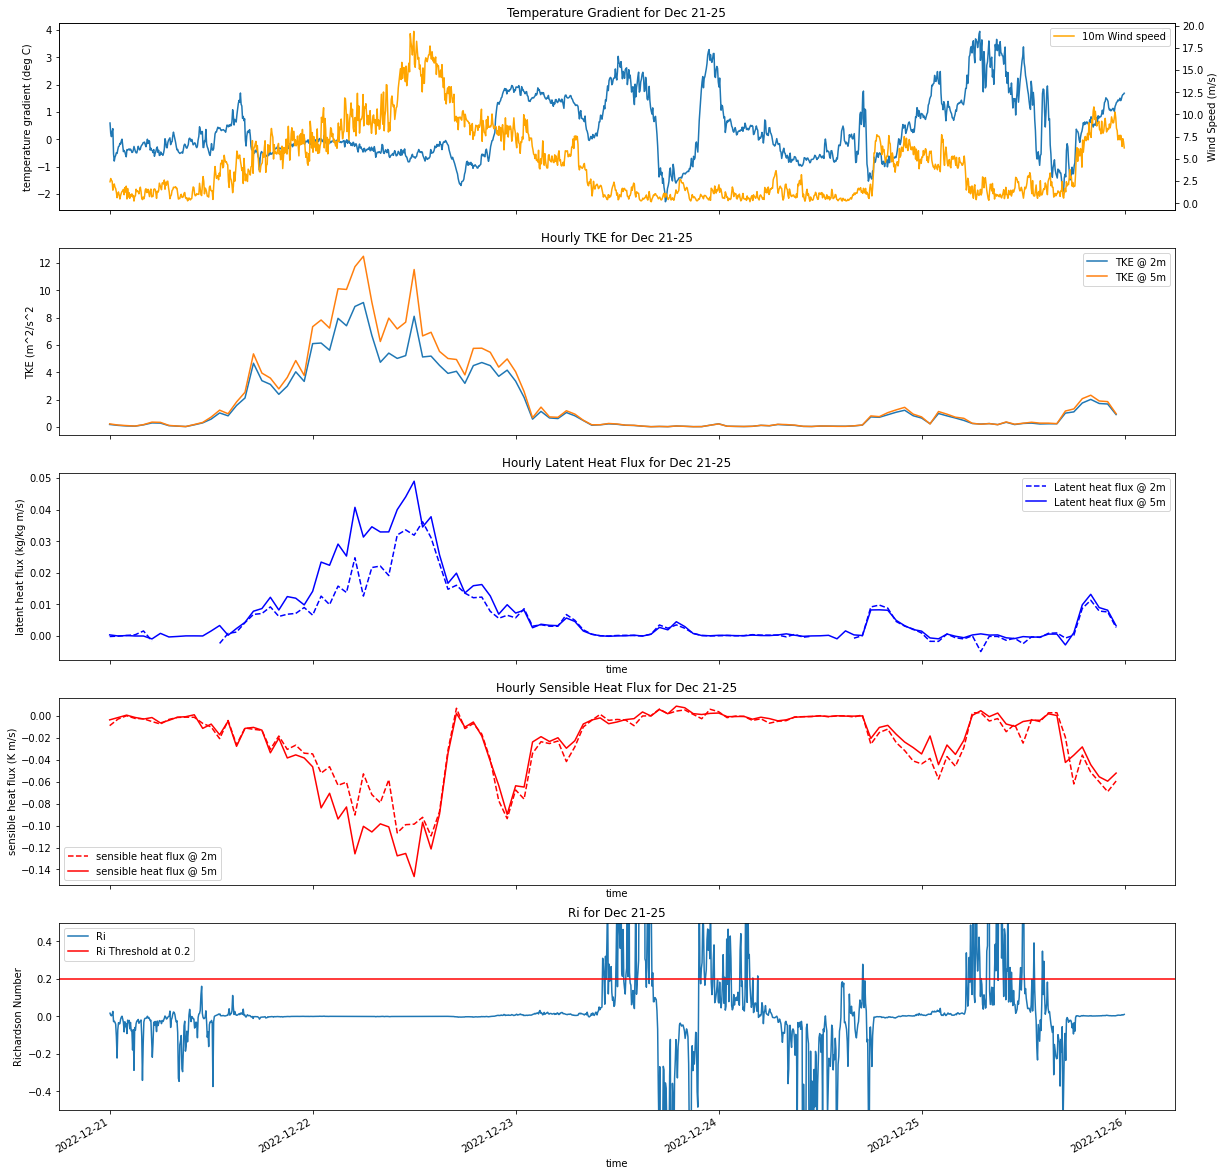

In [10]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5,1, figsize=(20,20), sharex=True)

temp_gradient.sel().plot(ax=axes[0])
ax2 = axes[0].twinx()
sos_ds['spd_10m_c'].plot(ax=ax2, color='orange', label='10m Wind speed')
ax2.set_ylabel('Wind Speed (m/s)')
ax2.legend()

sos_ds['tke_2m_c'].resample(time='1H').mean().plot(ax=axes[1], label='TKE @ 2m')
sos_ds['tke_5m_c'].resample(time='1H').mean().plot(ax=axes[1], label = 'TKE @ 5m')
sos_ds['w_h2o__2m_c'].resample(time='1H').mean().plot(ax=axes[2], label='Latent heat flux @ 2m', color='blue', ls='--')
sos_ds['w_h2o__5m_c'].resample(time='1H').mean().plot(ax=axes[2], label='Latent heat flux @ 5m', color='blue')
sos_ds['w_tc__2m_c'].resample(time='1H').mean().plot(ax=axes[3], label='sensible heat flux @ 2m', color='red', ls='--')
sos_ds['w_tc__5m_c'].resample(time='1H').mean().plot(ax=axes[3], label='sensible heat flux @ 5m', color='red')
Ri.sel().plot(ax=axes[4], label='Ri')
axes[4].axhline(0.2, label='Ri Threshold at 0.2', color='r')

axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[0].set_ylabel("temperature gradient (deg C)")
axes[1].set_ylabel("TKE (m^2/s^2")
axes[2].set_ylabel("latent heat flux (kg/kg m/s)")
axes[3].set_ylabel("sensible heat flux (K m/s)")
axes[4].set_ylabel("Richardson Number")

axes[0].set_title('Temperature Gradient for Dec 21-25')
axes[1].set_title('Hourly TKE for Dec 21-25')
axes[2].set_title('Hourly Latent Heat Flux for Dec 21-25')
axes[3].set_title('Hourly Sensible Heat Flux for Dec 21-25')
axes[4].set_title('Ri for Dec 21-25')

axes[4].set_ylim(-0.5, 0.5)
for ax in axes:
    ax.legend()
plt.show()

Text(0.5, 1.0, 'Ri < 0.1 Sensible Heat')

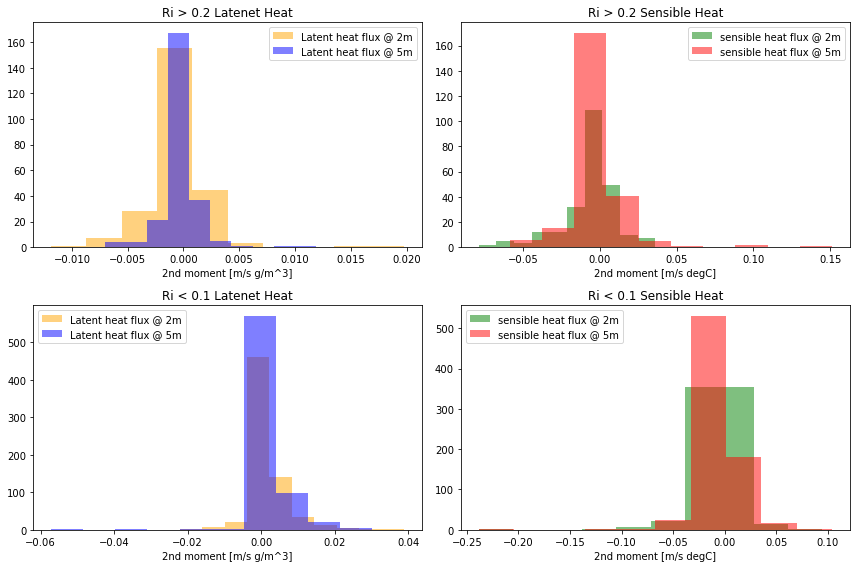

In [20]:
sos_ds_stable = sos_ds.where(Ri > 0.2)
sos_ds_near_neutral = sos_ds.where(Ri < 0.1)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,8), tight_layout=True, )
axes = axes.ravel()


sos_ds_stable['w_h2o__2m_c'].plot.hist(ax=axes[0], label='Latent heat flux @ 2m', color='orange', alpha=0.5)
sos_ds_stable['w_h2o__5m_c'].plot.hist(ax=axes[0], label='Latent heat flux @ 5m', color='blue', alpha=0.5)
sos_ds_stable['w_tc__2m_c'].plot.hist(ax=axes[1], label='sensible heat flux @ 2m', color='green', alpha=0.5)
sos_ds_stable['w_tc__5m_c'].plot.hist(ax=axes[1], label='sensible heat flux @ 5m', color='red', alpha=0.5)

sos_ds_near_neutral['w_h2o__2m_c'].plot.hist(ax=axes[2], label='Latent heat flux @ 2m', color='orange', alpha=0.5)
sos_ds_near_neutral['w_h2o__5m_c'].plot.hist(ax=axes[2], label='Latent heat flux @ 5m', color='blue', alpha=0.5)
sos_ds_near_neutral['w_tc__2m_c'].plot.hist(ax=axes[3], label='sensible heat flux @ 2m', color='green', alpha=0.5)
sos_ds_near_neutral['w_tc__5m_c'].plot.hist(ax=axes[3], label='sensible heat flux @ 5m', color='red', alpha=0.5)
for ax in axes:
    ax.legend()
axes[0].set_title('Ri > 0.2 Latenet Heat')
axes[1].set_title('Ri > 0.2 Sensible Heat')
axes[2].set_title('Ri < 0.1 Latenet Heat')
axes[3].set_title('Ri < 0.1 Sensible Heat')

### Discussion:
For this first period, we see near-neutral conditions persisted for the first few days of the time series with a weak temperature gradient, strong winds, and small richardson numbers. The strongest signals for TKE, sensible, and latent heat appeared to occur during the windy period on the 22nd of December. The high wind speed corresponds with large amounts of TKE and more efficient transfer of turbulent energy near the surface. The fluxes closer to the surface at 2m appear to be slightly smaller in magnitude than the values at 5m. This difference is most apparent during the strong wind event on the 22nd. During strongly stable conditions that came up around the 26th, maximum latent heat values were approximately normally distributed around 0, with values that were an order of magnitude less than any near-neutral or unstable conditions that occured. It is interensting to note how the distribution for the near neutral conditions is rather different (more skewed) than the stable conditions. I imagine this is due to actual transport of mass and energy during these near-neurtral times as opposed to random oscillations around zero during stable periods. Sensible heat flux during near neutreal and stable conditions were somewhat similar, but the maximum values were larger during the near-neutral conditions. With more turbulent energy available to transport heat and water vapor during these near-neutral conditions, we see larger magnitudes in sensible and latent heat flux.

### Period 2: 1/11 - 1/14
For each, assess the stability, the winds, the Richardson number, and the turbulent fluxes (TKE and sensible and latent heat fluxes, at two or more different heights). How are these related? What are the highest turbulent fluxes you observe during a period considered “strongly stable,” with a Richardson number greater than 0.2?

In [12]:
sos_ds = ds_list[1]

In [13]:
g = 9.81 # m/s^2

temp_gradient =  (sos_ds['Tpotvirtual_2m_c'] - sos_ds['Tsurfpotvirtual_rad_c']) / (2)
bouyancy_term = (g / (273.15 + sos_ds['Tvirtual_2m_c'])) * temp_gradient
flow_shear_term = (sos_ds['spd_2m_c']/2)**2
Ri = bouyancy_term / flow_shear_term

No handles with labels found to put in legend.


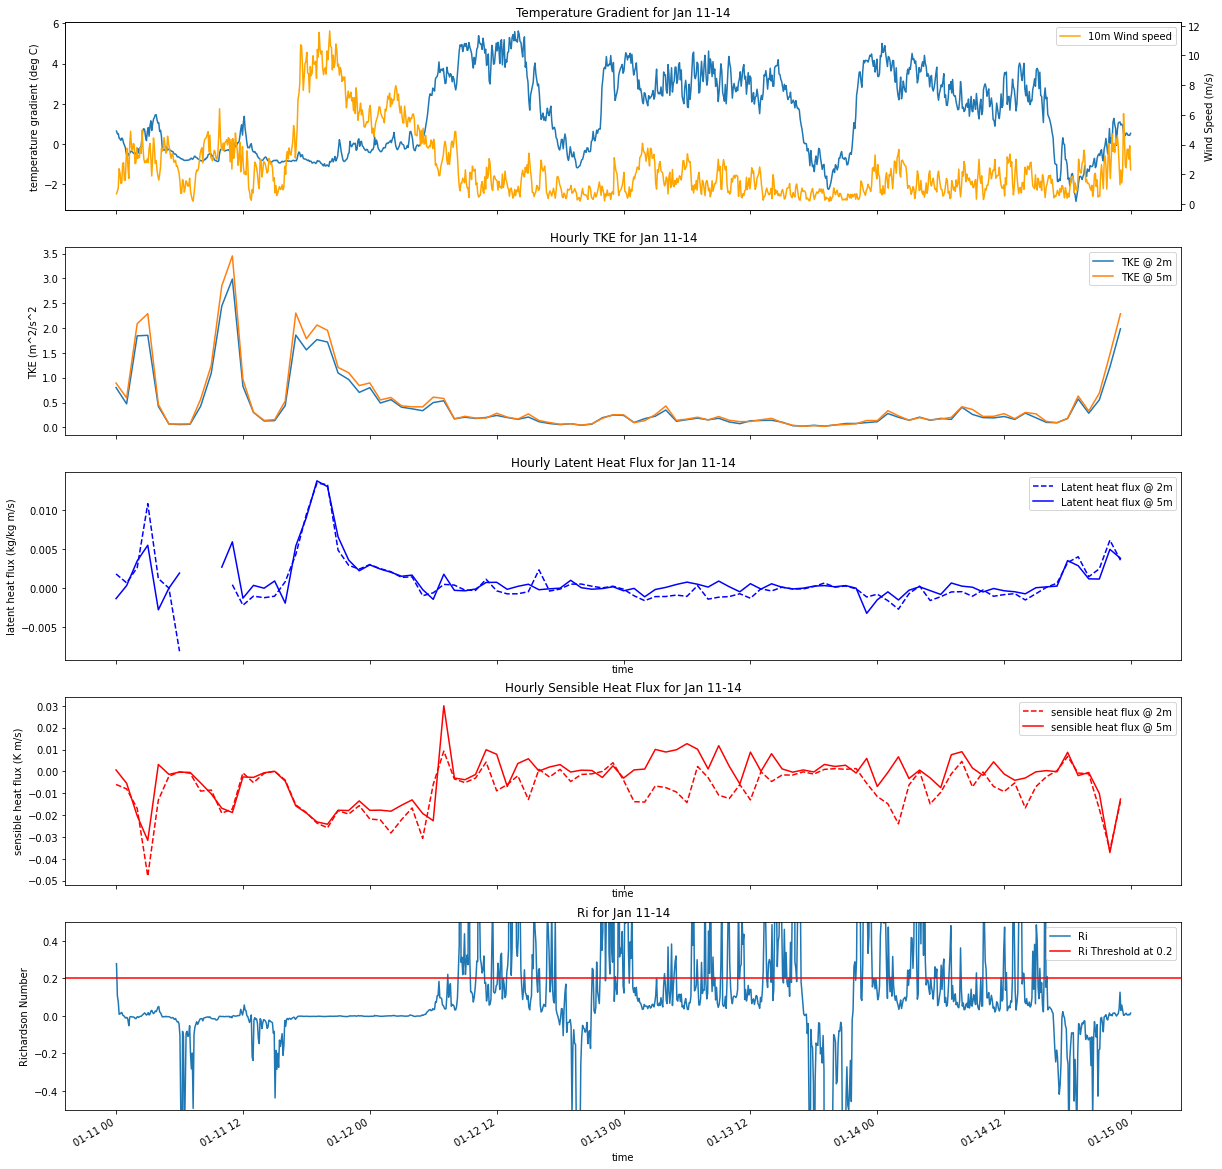

In [14]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5,1, figsize=(20,20), sharex=True)

temp_gradient.sel().plot(ax=axes[0])
ax2 = axes[0].twinx()
sos_ds['spd_10m_c'].plot(ax=ax2, color='orange', label='10m Wind speed')
ax2.set_ylabel('Wind Speed (m/s)')
ax2.legend()

sos_ds['tke_2m_c'].resample(time='1H').mean().plot(ax=axes[1], label='TKE @ 2m')
sos_ds['tke_5m_c'].resample(time='1H').mean().plot(ax=axes[1], label = 'TKE @ 5m')
sos_ds['w_h2o__2m_c'].resample(time='1H').mean().plot(ax=axes[2], label='Latent heat flux @ 2m', color='blue', ls='--')
sos_ds['w_h2o__5m_c'].resample(time='1H').mean().plot(ax=axes[2], label='Latent heat flux @ 5m', color='blue')
sos_ds['w_tc__2m_c'].resample(time='1H').mean().plot(ax=axes[3], label='sensible heat flux @ 2m', color='red', ls='--')
sos_ds['w_tc__5m_c'].resample(time='1H').mean().plot(ax=axes[3], label='sensible heat flux @ 5m', color='red')
Ri.sel().plot(ax=axes[4], label='Ri')
axes[4].axhline(0.2, label='Ri Threshold at 0.2', color='r')

axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[0].set_ylabel("temperature gradient (deg C)")
axes[1].set_ylabel("TKE (m^2/s^2")
axes[2].set_ylabel("latent heat flux (kg/kg m/s)")
axes[3].set_ylabel("sensible heat flux (K m/s)")
axes[4].set_ylabel("Richardson Number")

axes[0].set_title('Temperature Gradient for Jan 11-14')
axes[1].set_title('Hourly TKE for Jan 11-14')
axes[2].set_title('Hourly Latent Heat Flux for Jan 11-14')
axes[3].set_title('Hourly Sensible Heat Flux for Jan 11-14')
axes[4].set_title('Ri for Jan 11-14')

axes[4].set_ylim(-0.5, 0.5)
for ax in axes:
    ax.legend()
plt.show()

Text(0.5, 1.0, 'Ri < 0.1 Sensible Heat')

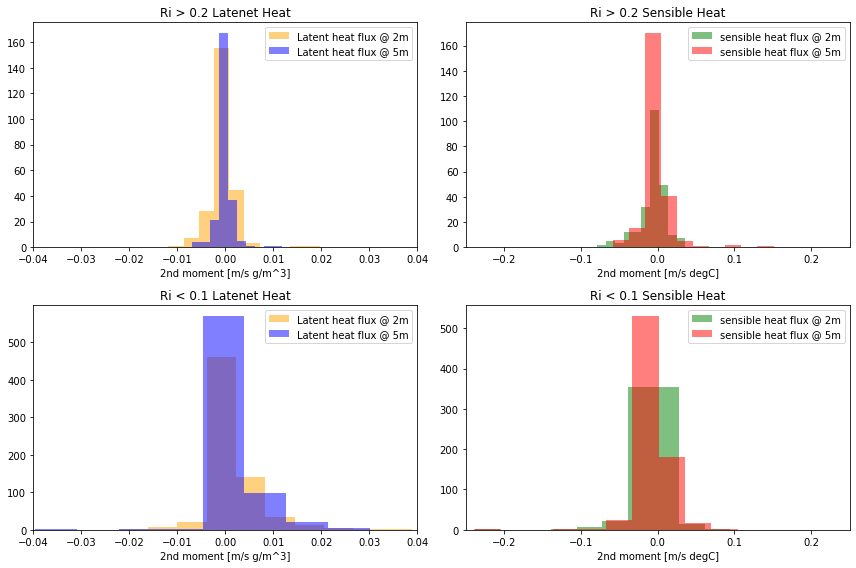

In [19]:
sos_ds_stable = sos_ds.where(Ri > 0.2)
sos_ds_near_neutral = sos_ds.where(Ri < 0.1)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,8), tight_layout=True)
axes = axes.ravel()


sos_ds_stable['w_h2o__2m_c'].plot.hist(ax=axes[0], label='Latent heat flux @ 2m', color='orange', alpha=0.5)
sos_ds_stable['w_h2o__5m_c'].plot.hist(ax=axes[0], label='Latent heat flux @ 5m', color='blue', alpha=0.5)
sos_ds_stable['w_tc__2m_c'].plot.hist(ax=axes[1], label='sensible heat flux @ 2m', color='green', alpha=0.5)
sos_ds_stable['w_tc__5m_c'].plot.hist(ax=axes[1], label='sensible heat flux @ 5m', color='red', alpha=0.5)
axes[0].set_xlim(-0.040, 0.040)
axes[2].set_xlim(-0.040, 0.040)

axes[1].set_xlim(-0.25, 0.25)
axes[3].set_xlim(-0.25, 0.25)


sos_ds_near_neutral['w_h2o__2m_c'].plot.hist(ax=axes[2], label='Latent heat flux @ 2m', color='orange', alpha=0.5)
sos_ds_near_neutral['w_h2o__5m_c'].plot.hist(ax=axes[2], label='Latent heat flux @ 5m', color='blue', alpha=0.5)
sos_ds_near_neutral['w_tc__2m_c'].plot.hist(ax=axes[3], label='sensible heat flux @ 2m', color='green', alpha=0.5)
sos_ds_near_neutral['w_tc__5m_c'].plot.hist(ax=axes[3], label='sensible heat flux @ 5m', color='red', alpha=0.5)
for ax in axes:
    ax.legend()
axes[0].set_title('Ri > 0.2 Latenet Heat')
axes[1].set_title('Ri > 0.2 Sensible Heat')
axes[2].set_title('Ri < 0.1 Latenet Heat')
axes[3].set_title('Ri < 0.1 Sensible Heat')


### Discussion:
During this mid-January period, we see much of the same characteristics as the last period, but with stronger and more continuous stability. Stability appears to break down during the day as the temperature gradient drops and Ri values go below 0 with little wind. The small amounts of wind allow for the Ri to become large in the absolute sense and changes dramatically depending on whether or not it is day. Over this period, the latent and sensible heat fluxes appear to be a lot more similar to one another in their distributions, although during neutral conditions the latent heat flux still looks a bit skewed. The range of the stable period fluxes is smaller, but not by the same magnitude as in the December case above.

### Period 3: 4/2 - 4/5
For each, assess the stability, the winds, the Richardson number, and the turbulent fluxes (TKE and sensible and latent heat fluxes, at two or more different heights). How are these related? What are the highest turbulent fluxes you observe during a period considered “strongly stable,” with a Richardson number greater than 0.2?

In [24]:
sos_ds = ds_list[2]

In [25]:
g = 9.81 # m/s^2

temp_gradient =  (sos_ds['Tpotvirtual_2m_c'] - sos_ds['Tsurfpotvirtual_rad_c']) / (2)
bouyancy_term = (g / (273.15 + sos_ds['Tvirtual_2m_c'])) * temp_gradient
flow_shear_term = (sos_ds['spd_2m_c']/2)**2
Ri = bouyancy_term / flow_shear_term

No handles with labels found to put in legend.


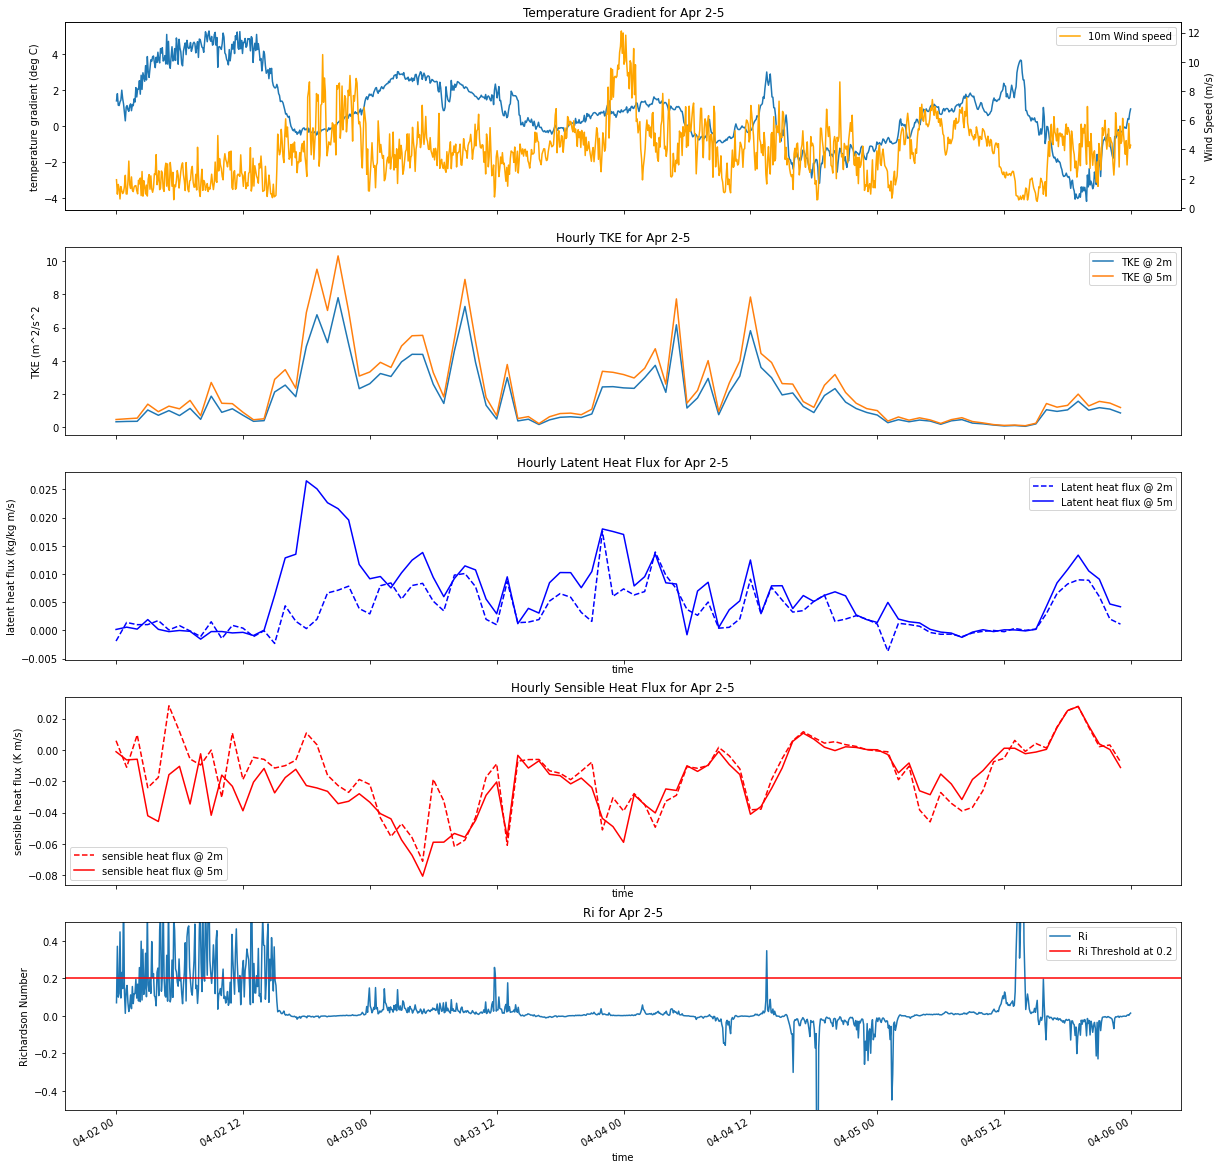

In [26]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5,1, figsize=(20,20), sharex=True)

temp_gradient.sel().plot(ax=axes[0])
ax2 = axes[0].twinx()
sos_ds['spd_10m_c'].plot(ax=ax2, color='orange', label='10m Wind speed')
ax2.set_ylabel('Wind Speed (m/s)')
ax2.legend()

sos_ds['tke_2m_c'].resample(time='1H').mean().plot(ax=axes[1], label='TKE @ 2m')
sos_ds['tke_5m_c'].resample(time='1H').mean().plot(ax=axes[1], label = 'TKE @ 5m')
sos_ds['w_h2o__2m_c'].resample(time='1H').mean().plot(ax=axes[2], label='Latent heat flux @ 2m', color='blue', ls='--')
sos_ds['w_h2o__5m_c'].resample(time='1H').mean().plot(ax=axes[2], label='Latent heat flux @ 5m', color='blue')
sos_ds['w_tc__2m_c'].resample(time='1H').mean().plot(ax=axes[3], label='sensible heat flux @ 2m', color='red', ls='--')
sos_ds['w_tc__5m_c'].resample(time='1H').mean().plot(ax=axes[3], label='sensible heat flux @ 5m', color='red')
Ri.sel().plot(ax=axes[4], label='Ri')
axes[4].axhline(0.2, label='Ri Threshold at 0.2', color='r')

axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[0].set_ylabel("temperature gradient (deg C)")
axes[1].set_ylabel("TKE (m^2/s^2")
axes[2].set_ylabel("latent heat flux (kg/kg m/s)")
axes[3].set_ylabel("sensible heat flux (K m/s)")
axes[4].set_ylabel("Richardson Number")

axes[0].set_title('Temperature Gradient for Apr 2-5')
axes[1].set_title('Hourly TKE for Apr 2-5')
axes[2].set_title('Hourly Latent Heat Flux for Apr 2-5')
axes[3].set_title('Hourly Sensible Heat Flux for Apr 2-5')
axes[4].set_title('Ri for Apr 2-5')

axes[4].set_ylim(-0.5, 0.5)
for ax in axes:
    ax.legend()
plt.show()

Text(0.5, 1.0, 'Ri < 0.1 Sensible Heat')

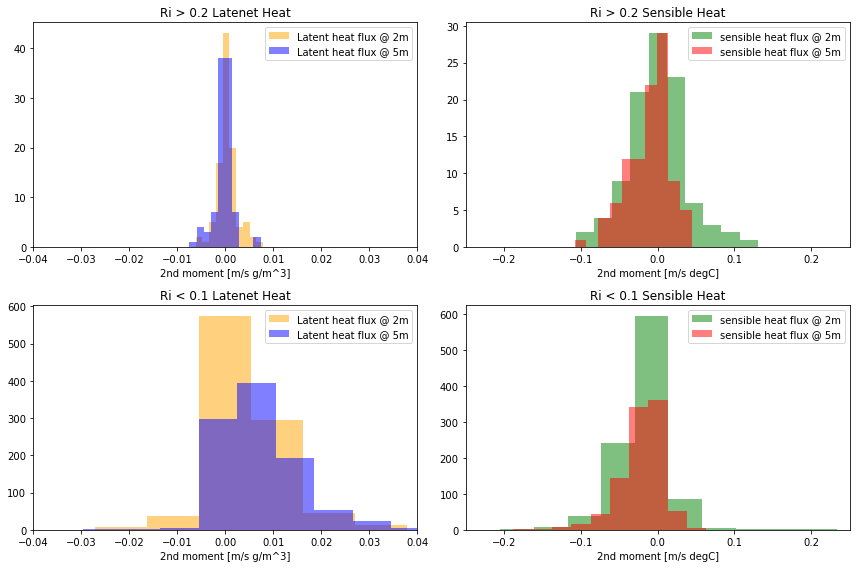

In [27]:
sos_ds_stable = sos_ds.where(Ri > 0.2)
sos_ds_near_neutral = sos_ds.where(Ri < 0.1)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,8), tight_layout=True)
axes = axes.ravel()


sos_ds_stable['w_h2o__2m_c'].plot.hist(ax=axes[0], label='Latent heat flux @ 2m', color='orange', alpha=0.5)
sos_ds_stable['w_h2o__5m_c'].plot.hist(ax=axes[0], label='Latent heat flux @ 5m', color='blue', alpha=0.5)
sos_ds_stable['w_tc__2m_c'].plot.hist(ax=axes[1], label='sensible heat flux @ 2m', color='green', alpha=0.5)
sos_ds_stable['w_tc__5m_c'].plot.hist(ax=axes[1], label='sensible heat flux @ 5m', color='red', alpha=0.5)
axes[0].set_xlim(-0.040, 0.040)
axes[2].set_xlim(-0.040, 0.040)

axes[1].set_xlim(-0.25, 0.25)
axes[3].set_xlim(-0.25, 0.25)


sos_ds_near_neutral['w_h2o__2m_c'].plot.hist(ax=axes[2], label='Latent heat flux @ 2m', color='orange', alpha=0.5)
sos_ds_near_neutral['w_h2o__5m_c'].plot.hist(ax=axes[2], label='Latent heat flux @ 5m', color='blue', alpha=0.5)
sos_ds_near_neutral['w_tc__2m_c'].plot.hist(ax=axes[3], label='sensible heat flux @ 2m', color='green', alpha=0.5)
sos_ds_near_neutral['w_tc__5m_c'].plot.hist(ax=axes[3], label='sensible heat flux @ 5m', color='red', alpha=0.5)
for ax in axes:
    ax.legend()
axes[0].set_title('Ri > 0.2 Latenet Heat')
axes[1].set_title('Ri > 0.2 Sensible Heat')
axes[2].set_title('Ri < 0.1 Latenet Heat')
axes[3].set_title('Ri < 0.1 Sensible Heat')


This final period was characterized as a stable period followed by a multi-day near-neutral period that rarely became either stable or unstable. Wind speed was generally  high over this set of days. With relatively warmer spring temperatures and stormy conditions, the Ri was near zero. Sensible heat fluxes generally remained below 0 while latent heat fluxes remained above. The histograms above show how the distribution changed during the stable and near-neutral events. Genearlly the latent heat flux again did not follow the same distribtuion for different conditions, but sensible heat did follow a very similar distribution between the two cases. Here, we also see some rather large differences in the latent heat flux between 2 and 5 meters during one of the earlier periods in this time series with stronger winds. The divergence between values at different levels appears to occur most during large wind events when significant transer is possible in the form of sensible and latent heat fluxes.

### Problem 2 Mass vs Energy Fluxes in Sublimation

Consider again, the major wind event of 22 December 2021 that moved a fair bit of snow around. Over the 24-hour period of measured blowing snow at 1 m (as documented by the FlowCapt sensor), calculate 
- (a) the total mass (in grams/m^2) of snow that horizontally moved past the sensor, 
- (b) the total mass (in grams/m^2) of water vapor that was transported vertically away from the snow over this time interval, 
- (c) the total energy (in Joules, using the latent heat of sublimation) that went into converting snow to the amount of water vapor calculated in b, and 
- (d) the total energy change per m^2 area, in the snowpack, calculated with the specific heats of ice and air, the density of the snow to represent fractional ice content, the depth over which a change was observed, and the observed temperature change (as measured from the thermistors in the snowpack at this time).

 (a) the total mass (in grams/m^2) of snow that horizontally moved past the sensor, 


In [30]:
sos_wind_snowflux = xr.open_dataset('../HW-4/sos_wind_snowflux.nc')
time_slice = slice('2022-12-22','2022-12-23')
sos_wind_snowflux.sel(time=time_slice)['SF_avg_1m_ue'].mean() * 3600*24

<xarray.DataArray 'SF_avg_1m_ue' ()>
array(474046.14715576)

According to my calculations, 474,046 g/m$^2$ of snow moved passed the 1m flowcapt sensor over the day. Thats a total of 474 kilograms per m$^2$. That is about 24 Denali's racing passed over the day, once per hour! To me that does seem like a very large amount of snow given that we had less than a meter, but it could be feasible (wish I had been there to witness it!). Since this event was 2 orders of magnitude larger than any other event we saw this winter, I wonder if this is either a testament to the extremity of the event or truly an erroneous value. 

(b) the total mass (in grams/m^2) of water vapor that was transported vertically away from the snow over this time interval, 

In [46]:
dec22_sublimation = (ds_list[0].sel(time=time_slice)[['w_h2o__2m_c','w_h2o__3m_uw','w_h2o__3m_ue','w_h2o__3m_d']].mean() * 3600 * 24).to_pandas().mean()
print(dec22_sublimation)

937.9190325737


938 g/m$^2$ of water moved vertically away from the surface during this day, right around 1 kg of water per square meter.

(c) the total energy (in Joules, using the latent heat of sublimation) that went into converting snow to the amount of water vapor calculated in b 

In [51]:
Lv = 2.835e3 # J/g
sublimation_energy = dec22_sublimation * Lv
print(f'{sublimation_energy} J/m2')

2659000.4573464394 J/m2


In [53]:
_convert_to_calories = 4.18
print(f'{sublimation_energy / 1000 / _convert_to_calories} calories')

636.1245113268994 calories


The total amount of energy that went into sublimating this snow was around 2.66e6 J/$m^2$ . That is about the same amount of energy (as calories) in 3 4-piece kit-kat bars.

(d) the total energy change per m^2 area, in the snowpack, calculated with the specific heats of ice and air, the density of the snow to represent fractional ice content, the depth over which a change was observed, and the observed temperature change (as measured from the thermistors in the snowpack at this time).

In [61]:
lidar_depth = xr.open_dataarray('../HW-4/lidar/lidar_l4_pillow_depths.nc').sel(time=time_slice)
sos_swe = xr.open_dataset('../data/sos_SWE_T_P.nc').sel(time=time_slice)

In [77]:
density = (sos_swe.sel(time=['2022-12-22T00:00:00.000000000','2022-12-23T00:00:00.000000000']) / 1000)['SWE_p3_c'] / lidar_depth.sel(pillow='UE', stat='mean')
print(density)

<xarray.DataArray (time: 2)>
array([0.09475988, 0.35519948])
Coordinates:
  * time     (time) datetime64[ns] 2022-12-22 2022-12-23
    stat     <U4 'mean'
    pillow   <U2 'UE'


The bottom three thermistors were buried over the day at UW. Lets compute out temperature delta from the surface to the 0.4 thermistor.

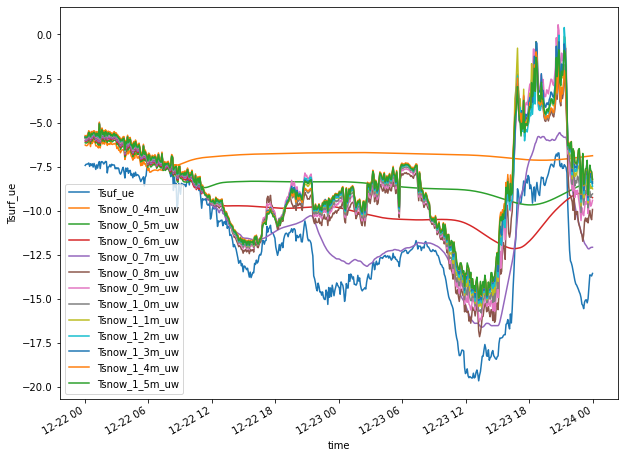

In [99]:
fig, ax = plt.subplots(figsize=(10,8))
ds_list[0]['Tsurf_ue'].sel(time=time_slice).plot(ax=ax,label='Tsuf_ue')
ds_list[0].sel(time=time_slice)[[ 'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw']].to_pandas().plot(ax=ax)
ax.legend()

Change is energy with depth is equal to the energy needed to head snow and air multiplied by the difference layer temperature.
$$ dE/dz = (cp_{ice}*(d\rho_{snow}) + cp_{air}*(d(1-\rho_{snow}))  ) * dT/dt$$
$$ dE = (cp_{ice}*(d\rho_{snow}) + cp_{air}*(d(1-\rho_{snow}))  ) * dT * dz /dt$$

In [105]:
cp_ice = 2.03 # J/g K
cp_air = 1.006 # J/g/K

dz = 0.3 # height over which change occured in meters

delta_density = dz * 1000 * ((density.values[1] - density.values[0]) * cp_ice + ((1- density.values[1]) - (1 - density.values[0])) * cp_air)

For this last calculation, I'm a bit unsure what $dt$ should be, so I decided to integrate over the entire day to see what the value looks like.

In [117]:
delta_E = delta_density * (ds_list[0]['Tsurf_ue'].sel(time=time_slice) - ds_list[0].sel(time=time_slice)[ 'Tsnow_0_4m_uw'])
delta_E.sum()


<xarray.DataArray ()>
array(-224868.53, dtype=float32)

Here I got -224868 J/m2 of energy as the energy deficit within the snowpack generated on December 22. I think I may have used $dt$ incorrectly here. The value is much less than the energy lost to the atmosphere due to the sublimation we computed above (about an order of magnitude shy).